# 1. Image Transforms

In [1]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# !git clone https://github.com/jaddoescad/ants_and_bees.git ../data

In [4]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0,shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.ImageFolder(root="../data/ants_and_bees-master/train", transform=transform_train)
validation_dataset = datasets.ImageFolder(root="../data/ants_and_bees-master/val", transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=True)

In [5]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [6]:
class DeNormalize(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
def im_convert(tensor):
#     denorm = DeNormalize(mean=(0.5,), std=(0.5,))
    transform = transforms.Compose([DeNormalize((0.5,), (0.5,))])

    tensor = transform(tensor.clone().detach())
    tensor = tensor.permute(1,2,0)
    image = tensor.clip(0,1).cpu()
    return image

In [7]:
classes = ("ant", "bee")

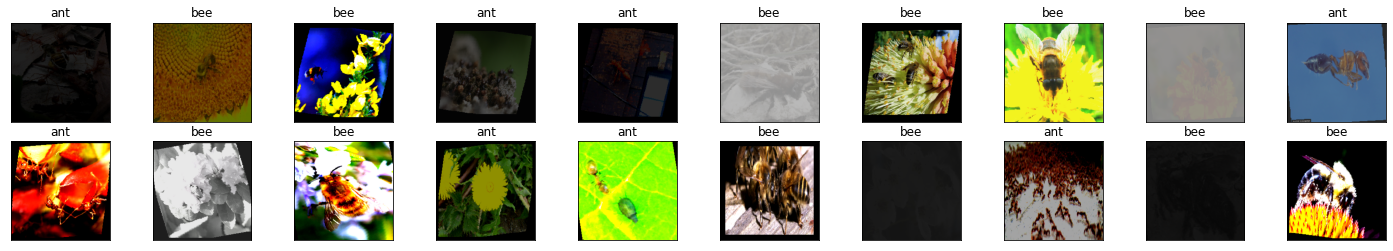

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# 2. Neural Network Implementaion

## VGG

![](../resources/vgg.png)

In [43]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [44]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
for param in model.features.parameters():
    param.requires_grad = False

In [46]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
# model.reset_parameters()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [49]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        # images shape: 1, 28, 28
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                # images shape: 1, 28, 28
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                                     
        epoch_loss = running_loss/len(training_loader.dataset)
        epoch_acc = running_corrects.float()/len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print(f"epoch: {e+1}")
        print(f"training loss: {epoch_loss:.4f} acc: {epoch_acc.item():.4f} ")
        print(f"validation loss: {val_epoch_loss:.4f} validation acc: {val_epoch_acc.item():.4f} ")

epoch: 1
training loss: 0.0167 acc: 0.8607 
validation loss: 0.0115 validation acc: 0.9150 
epoch: 2
training loss: 0.0126 acc: 0.8852 
validation loss: 0.0166 validation acc: 0.9085 
epoch: 3
training loss: 0.0161 acc: 0.8648 
validation loss: 0.0157 validation acc: 0.9216 
epoch: 4
training loss: 0.0117 acc: 0.8730 
validation loss: 0.0167 validation acc: 0.9281 
epoch: 5
training loss: 0.0117 acc: 0.8934 
validation loss: 0.0181 validation acc: 0.9216 


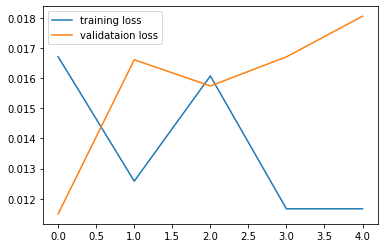

In [51]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validataion loss")
plt.legend()

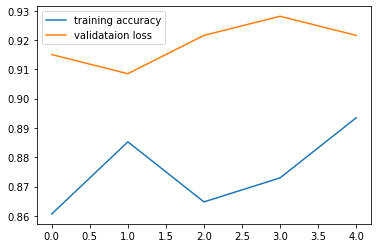

In [52]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validataion loss")
plt.legend()

# 3. Test Model

### Preprocess Image

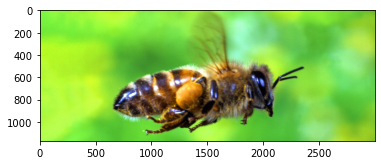

In [53]:
import requests
from PIL import Image, ImageOps
url = "https://media.istockphoto.com/photos/ant-picture-id181123699?s=612x612"
url = "https://www.britannica.com/explore/savingearth/wp-content/uploads/sites/4/2019/03/bee-corridors-hero.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

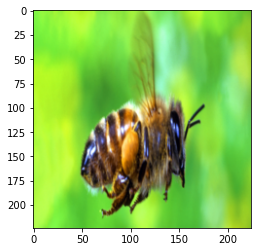

In [54]:
img = transform(img)
plt.imshow(im_convert(img))

### Predict

In [55]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


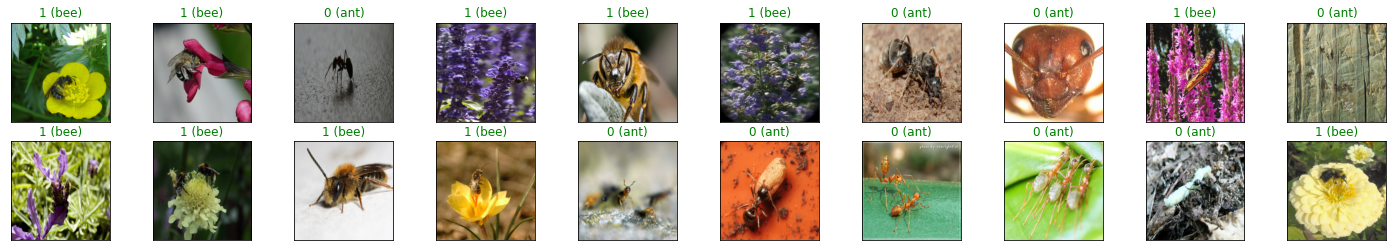

In [56]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f"{preds[idx].item()} ({classes[labels[idx].item()]})", color=("green" if preds[idx]==labels[idx] else "red"))

# Appendix

## AlexNet

![](../resources/alexnet.png)

In [9]:
model = models.alexnet(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False
    
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

![](../resources/alexnet_result.png)